# Zadanie

Klasyfikacja za pomocą naiwnej metody bayesowskiej (rozkłady ciągłe). Implementacja powinna założyć, że cechy są ciągłe (do wyboru rozkład normalny i jądrowe wygładzenie). Na wejściu oczekiwany jest zbiór, który zawiera p-cech ciągłych, wektor etykiet oraz wektor prawdopodobieństw a priori dla klas. Na wyjściu otrzymujemy prognozowane etykiety oraz prawdopodobieństwa a posteriori. Dodatkową wartością może być wizualizacja obszarów decyzyjnych w przypadku dwóch cech.


# Zbiór danych

Do prezentacji wyników użyliśmy danych pochodzących z [UCI ML Breast Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic). Zbiór zawiera 30 cech, na podstawie których klasyfikowany jest nowotwór - jako złośliwy lub niezsłośliwy.

![Grafika zaciągnięta z internetu](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*pxFCmhRFTighUn88baLcSA.png)
    

In [66]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

breast_cancer = load_breast_cancer()

# Sprawdzenie poprawności rozmiarów
assert len(breast_cancer.data[0]) == len(breast_cancer.feature_names)
assert len(breast_cancer.target) == len(breast_cancer.data)

values = np.c_[breast_cancer.data, breast_cancer.target]
columns = np.array(list(breast_cancer.feature_names) + ['target'])

df = pd.DataFrame(values, columns=columns)

X = df.iloc[:, 0:-1]
y = df.iloc[:,-1]

df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890     0.0  
1          0.2750                  0.08902     0.0  
2          0.3613                  0.08758     0.0  
3          0.6638                  0.17300     0.0  
4          0.2364                  0.07678     0.0  

[5 rows x 31 columns]

# Implementacja naiwnej metody Bayesowskiej

Implementacja jest w dwóch wariantach:
- Rozkład normalny - Gaussian (Normal) Distribution
- Rozkład log-normalny - Log-Gaussian (Log-Normal) Distribution

# Matematyczny opis algorytmu

## Twierdzenie Bayesa

${X}$ będzie pewnym zdarzeniem o ${n}$ cechach $$ X = (x_1, x_2, \ldots, x_n)$$
prawdopodobieństwo a posteriori ${P(C_k | X)}$ dla klasy ${C_k}$ jest dane przez: $$P(C_k | X) = \frac{P(X | C_k) P(C_k)}{P(X)}$$

Gdzie:
$$
\begin{align*}
& \text{(1)}\hspace{1cm}P(C_k | X)\text{ to prawdopodobieństwo (probability) a posteriori klasy } C_k \text{ pod warunkiem zajścia zdarzenia } X \\
& \text{(2)}\hspace{1cm}P(X | C_k) \text{ to prawdopodobieństwo (likelihood) obserwacji zdarzenia } X \text{ pod warunkiem klasy } C_k \\
& \text{(3)}\hspace{1cm}P(C_k) \text{ to prawdopodobieństwo apriori klasy } C_k \\
& \text{(4)}\hspace{1cm}P(X) \text{ to całkowite prawdopodobieństwo obserwacji zdarzenia X we wszystkich klasach} \\
\end{align*}
$$


### Wzory na średnią i odchylenie standardowe

#### Średnia (Mean)

Średnia ${\mu}$ zestawu danych ${X}$ składającego się z ${n}$ obserwacji jest obliczana jako:

$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

Gdzie:
- ${\mu}$ to średnia (mean)
- ${n}$ to liczba obserwacji w zestawie danych
- ${x_i}$ to pojedyncza obserwacja w zestawie danych

#### Odchylenie standardowe (Standard Deviation)

Odchylenie standardowe ${ \sigma }$ zestawu danych ${ X }$ składającego się z ${ n }$ obserwacji jest obliczane jako pierwiastek kwadratowy z wariancji:

$$
\sigma = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2}
$$

Gdzie:
- ${\sigma}$ to odchylenie standardowe (standard deviation)
- ${\mu}$ to średnia (mean) zestawu danych
- ${n}$ to liczba obserwacji w zestawie danych
- ${x_i}$ to pojedyncza obserwacja w zestawie danych


### Prawdpodobiestwo (Likelihood) obserwacji zdarzenia - rozkład normalny
$$ 
\text{Likelihood}(x | \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right) 
$$

$$
\text{Posterior} = \text{Likelihood}  \times \text{Prior}
$$

### Prawdopodobieństwo (Log-Likelihood) obserwacji zdarzenia - rozkład log-normalny

$$
\text{Log-Likelihood}(x | \mu, \sigma) = -\frac{1}{2} \log(2\pi\sigma^2) - \frac{(x - \mu)^2}{2\sigma^2} 
$$

$$
\text{Log-Posterior} = \text{Log-Likelihood} + \text{Log-Prior}
$$

In [67]:
import numpy as np
from scipy.stats import norm

class GaussianNaiveBayes:
    def __init__(self, priors=None, var_smoothing=1e-8, log=False):
        self.priors = priors
        self.classes = None
        self.means = None
        self.stds = None
        self.log = log
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        self.epsilon = self.var_smoothing * np.var(X, axis=0).max()
        
        self.classes = np.unique(y)
        self.means = np.zeros((len(self.classes), X.shape[1]))
        self.stds = np.zeros((len(self.classes), X.shape[1]))
        
        for idx, cls in enumerate(self.classes):
            X_c = X[y == cls]
            self.means[idx, :] = X_c.mean(axis=0)
            self.stds[idx, :] = X_c.std(axis=0)

        if self.priors is None:
            self.priors = np.bincount(y) / len(y)

        self.stds += self.epsilon

    def predict(self, X):
        posteriors = self.predict_proba(X)
        return np.argmax(posteriors, axis=1)

    def score(self, X, y_true):
        posteriors = self.predict_proba(X)
        y_pred = np.argmax(posteriors, axis=1)

        correct_predictions = np.sum(y_true == y_pred)
        accuracy = correct_predictions / len(y_true)
        return accuracy

    def score_visualize(self, X, y_true):
        """
        Funkcja rysuje dwa wykresy słupkowe przedstawiające rzeczywiste wartości i przewidywane wartości.
        """
        posteriors = self.predict_proba(X)
        y_pred = np.argmax(posteriors, axis=1)

        # Liczymy ilość wystąpień każdej klasy dla rzeczywistych i przewidywanych wartości
        true_counts = np.bincount(y_true)
        pred_counts = np.bincount(y_pred)

        # Tworzymy subplots - dwa wykresy obok siebie
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Pierwszy wykres - rzeczywiste wartości
        axes[0].bar([0, 1], true_counts, color=['blue', 'orange'])
        axes[0].set_title('Rzeczywiste wartości')
        axes[0].set_xticks([0, 1])
        axes[0].set_xticklabels(['Nowotwór złośliwy', 'Nowotwór łagodny'])
        axes[0].set_ylabel('Liczba wystąpień')
        
        # Drugi wykres - przewidywane wartości
        axes[1].bar([0, 1], pred_counts, color=['blue', 'orange'])
        axes[1].set_title('Przewidywane wartości')
        axes[1].set_xticks([0, 1])
        axes[1].set_xticklabels(['Nowotwór złośliwy', 'Nowotwór łagodny'])
        axes[1].set_ylabel('Liczba wystąpień')
        
        # Wyświetlamy wykresy
        plt.show()

    def predict_proba(self, X):
        if self.log:
            return self._calculate_posterior_log(X)
        else:
            return self._calculate_posterior_normal_vectorized(X)

    def _normal_gaussian_pdf(self, x, mean, std):
        """
        Implementacja Normal Gaussian (likelihood) z użyciem SciKit - używana do testów
        """
        return np.prod(norm.pdf(x, mean, std))

    def normal_gaussian_pdf(self, x, mean, std):
        """
        implementacja Normal Gaussian (likelihood)

        kształt x jest zmieniany na (n_samples, 1, n_features) aby numpy mógł broadcastować
        operacje z mediąną, której kształt to (n_classes, n_features)
        """
        coefficient = 1 / (np.sqrt(2 * np.pi * std**2))
        exponent = np.exp(-(np.square(x[:, np.newaxis] - mean)) / (2 * np.square(std)))
        return coefficient * exponent
    
    def log_gaussian_pdf(self, x, mean, std):
        """
        implementacja Log-Normal Gaussian (likelihood)
        """
        return -0.5 * np.log(2 * np.pi * std**2) - ((x - mean)**2 / (2 * std**2))

    def _calculate_posterior_log(self, x):
        """
        Log-normal
        Użyliśmy log-sum-exp trick dla numerycznej stabilności.
        """
        log_likelihoods = np.zeros((x.shape[0], len(self.classes)))
        for idx, _ in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            log_likelihood = np.sum(self.log_gaussian_pdf(x, self.means[idx, :], self.stds[idx, :]), axis=1)
            log_likelihoods[:, idx] = log_likelihood + prior
        
        # The Log-Sum-Exp Trick
        max_log_likelihoods = np.max(log_likelihoods, axis=1, keepdims=True)
        log_posteriors = log_likelihoods - max_log_likelihoods
        posteriors = np.exp(log_posteriors)
        posteriors = posteriors / np.sum(posteriors, axis=1, keepdims=True)
        return posteriors
    
    def _calculate_posterior_normal_vectorized(self, X):
        """
        Implementacja z użyciem wektorów - zwraca takie same wyniki jak _calculate_posterior_normal_iterative
        Działa szybciej i pomija konieczność iteracji w pętli.
        """
        likelihoods = self.normal_gaussian_pdf(X, self.means, self.stds)
        posteriors = likelihoods.prod(axis=2) * self.priors
        posteriors = posteriors / np.sum(posteriors, axis=1, keepdims=True)
        return posteriors

    def _calculate_posterior_normal_iterative(self, X):
        """
        Implementacja iteracyjna - zwraca takie same wyniki _calculate_posterior_normal_vectorized
        Używana do testów, aby sprawdzić czy wersja z użyciem wektorów działa poprawnie
        """
        posteriors = []
        for x in X:
            likelihoods = np.zeros((len(self.classes)))
            for idx, _ in enumerate(self.classes):
                likelihoods[idx] = self._normal_gaussian_pdf(x, self.means[idx, :], self.stds[idx, ]) * self.priors[idx]
            posteriors.append(likelihoods)
        posteriors = np.array(posteriors)
        posteriors = posteriors / np.sum(posteriors, axis=1, keepdims=True)
        return posteriors

def pp_predictions(preds, probs):
    i = 1
    for pred, prob in zip(preds, probs):
        print(f"\n=== {i} ===")
        
        if pred == 0:
            print(f"Predykcja: {pred} - (Nowotwór złośliwy)")
        else:
            print(f"Predykcja: {pred} - (Nowotwór łagodny)")
      
        print(f"Prawdpodobieństwo (Złośliwy, Łagodny): {np.round(prob, 4)}")
        i += 1

# Prezentacja działania algorytmu

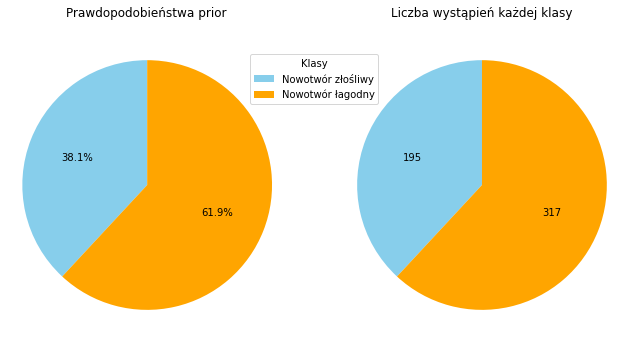

In [69]:
# Podział zbioru danych na treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=48)

gnb = GaussianNaiveBayes(log=False)
gnb.fit(X_train.values, y_train)

# Prawdopodobieństwa prior
priors = np.array(gnb.priors)
counts = [np.sum(y_train == 0.0), np.sum(y_train == 1.0)]

# Etykiety klas
labels = ['Nowotwór złośliwy', 'Nowotwór łagodny']

# Tworzenie diagramu kołowego
fig, axes = plt.subplots(1, 2, figsize=(11, 6), facecolor='white')

wedges, _, _ = axes[0].pie(priors, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
axes[0].axis('equal')  # Równe proporcje, aby koło było kołem
axes[0].set_title('Prawdopodobieństwa prior')

# Funkcja zwracająca liczbę dla autopct
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{absolute}"

axes[1].pie(counts, autopct=lambda pct: func(pct, counts), startangle=90, colors=['skyblue', 'orange'])
axes[1].axis('equal')  # Równe proporcje, aby koło było kołem
axes[1].set_title('Liczba wystąpień każdej klasy')

# Dodanie jednej legendy dla obu wykresów
fig.legend(wedges, labels, title="Klasy", loc="center right", bbox_to_anchor=(0.6, 0.75))

# Ustawienie białego tła dla wykresów
fig.patch.set_facecolor('white')

# Wyświetlenie wykresu
plt.show()

In [70]:
print(f"Prawdopodobieństwa prior: {gnb.priors}")
score = gnb.score(X_test.values, y_test)
print("Celność na zbiorze testowym:", score)

# Predykcje
preds = gnb.predict(X_test.values[15:20])
probs = gnb.predict_proba(X_test.values[15:20])
pp_predictions(preds, probs)

Prawdopodobieństwa prior: [0.38085938 0.61914062]
Celność na zbiorze testowym: 0.9824561403508771

=== 1 ===
Predykcja: 1 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0. 1.]

=== 2 ===
Predykcja: 1 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0.1798 0.8202]

=== 3 ===
Predykcja: 1 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0.0067 0.9933]

=== 4 ===
Predykcja: 1 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0.0472 0.9528]

=== 5 ===
Predykcja: 0 - (Nowotwór złośliwy)
Prawdpodobieństwo (Złośliwy, Łagodny): [1. 0.]


<Figure size 1008x1008 with 0 Axes>

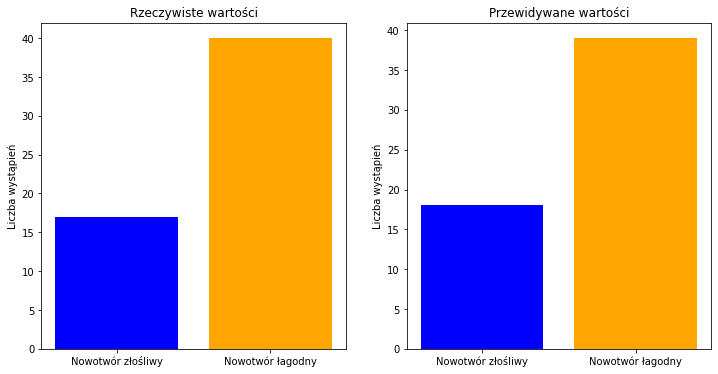

In [71]:
plt.figure(figsize=(14, 14))
score = gnb.score_visualize(X_test.values, y_test)

# Porównanie wyników z gotową implementacją z użyciem biblioteki sklearn

In [72]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train.values, y_train)
print("Celność na zbiorze testowym:", clf.score(X_test.values, y_test))
preds = clf.predict(X_test.values[15:20])
probs = clf.predict_proba(X_test.values[15:20])
pp_predictions(preds, probs)

Celność na zbiorze testowym: 0.9824561403508771

=== 1 ===
Predykcja: 1.0 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0. 1.]

=== 2 ===
Predykcja: 1.0 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0.1123 0.8877]

=== 3 ===
Predykcja: 1.0 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0. 1.]

=== 4 ===
Predykcja: 1.0 - (Nowotwór łagodny)
Prawdpodobieństwo (Złośliwy, Łagodny): [0.047 0.953]

=== 5 ===
Predykcja: 0.0 - (Nowotwór złośliwy)
Prawdpodobieństwo (Złośliwy, Łagodny): [1. 0.]


# Wizualizacja obszarów decyzyjnych

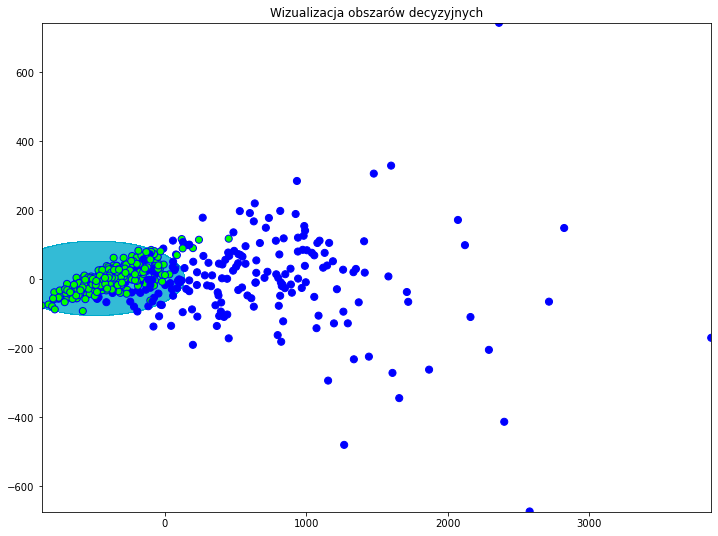

In [73]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

# Wizualizacja obszarów decyzyjnych
def plot_decision_boundaries(X, y, model, title, h=0.9):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12, 9))
    colors_background = ['#FFFFFF', '#00AACC']
    colors_points = ['#0000FF', '#00FF00']
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(colors_background))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='b', cmap=ListedColormap(colors_points))
    plt.title(title)
    plt.show()

# 30 cech zostało zredukowane do dwóch
# PCA dokonuje liniowej redukcji wymiarów za pomocą algorytmu Singular Value Decomposition (SVD).
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.values)

gnb = GaussianNaiveBayes(log=True)
gnb.fit(X_pca, y_train)
plot_decision_boundaries(X_pca, y_train, gnb, "Wizualizacja obszarów decyzyjnych")